In [1]:
import numpy as np
from sklearn import linear_model, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix as cm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import *
from collections import deque
from sklearn.tree import _tree as ctree
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('lab5.csv')

In [3]:
df.head()

Height    Weight  Male
0  73.84702  241.8936     1
1  68.78190  162.3105     1
2  74.11011  212.7409     1
3  71.73098  220.0425     1
4  69.88180  206.3498     1

Q1 Create a logistic regression model to predict the Sex of the person

In [4]:
x_columns = ['Height', 'Weight']
X = df[x_columns]
x1 = df['Height']
x2 = df['Weight']
y = df.Male

In [5]:
lin_clf = linear_model.LogisticRegression().fit(X, y)

C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [6]:
lin_clf.predict_proba(X)

array([[4.66914000e-06, 9.99995331e-01],
       [7.24068477e-01, 2.75931523e-01],
       [1.63987427e-03, 9.98360126e-01],
       ...,
       [9.94899001e-01, 5.10099871e-03],
       [6.86102415e-01, 3.13897585e-01],
       [9.99304987e-01, 6.95013232e-04]])

In [7]:
lin_clf.predict(X)

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

[[-0.47828345  0.19679841]]


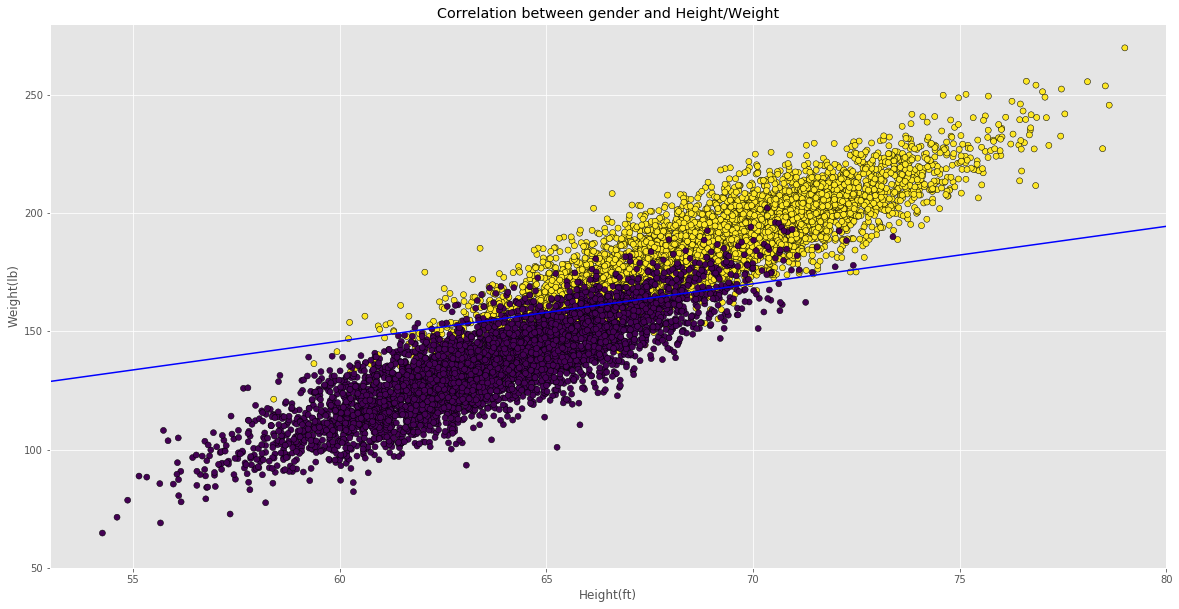

In [8]:
intercept = lin_clf.intercept_
coefs = lin_clf.coef_
coefs
print(coefs)

#figure
plt.figure(figsize=(20,10))
plt.title('Correlation between gender and Height/Weight')
plt.xlabel('Height(ft)')
plt.ylabel('Weight(lb)')
plt.scatter(x1,x2,c=y, edgecolors='k')
ex1 = np.linspace(50, 80, 250)
ex2 = -(coefs[:, 0] * ex1 + intercept) / coefs[:,1]
plt.plot(ex1, ex2, color='b')
plt.ylim(50,280)
plt.xlim(53,80)
plt.show()

In [9]:
all_ones = np.ones(len(y))
print('baseline ones accuracy: ', accuracy_score(y, all_ones))
all_ones = np.zeros(len(y))
print('baseline zeros accuracy: ', accuracy_score(y, all_ones))
y_pred = lin_clf.predict(X)
print('lin_clf accuracy: ', accuracy_score(y, y_pred))


confusion_matrix=cm(y, y_pred)
list1 = ["Actual 0", "Actual 1"]
list2 = ["Predicted 0", "Predicted 1"]
pd.DataFrame(confusion_matrix, list1,list2)

baseline ones accuracy:  0.5
baseline zeros accuracy:  0.5
lin_clf accuracy:  0.9195


Predicted 0  Predicted 1
Actual 0         4591          409
Actual 1          396         4604

Q1 End

Q2 Create a decision tree of depth 2 to predict the Sex of the person

In [34]:
dtree = DecisionTreeClassifier(max_depth = 2).fit(X,y)

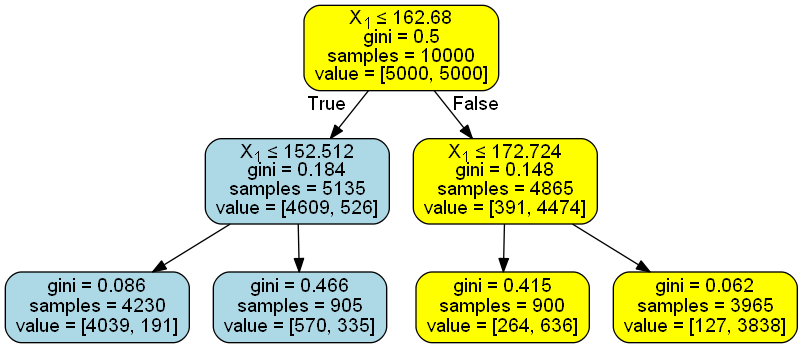

In [35]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os, sys
import collections

def conda_fix(graph):
        path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
        paths = ("dot", "twopi", "neato", "circo", "fdp")
        paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
        graph.set_graphviz_executables(paths)

dot_data = StringIO()

export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 

nodes = graph.get_node_list()

for node in nodes:
    if node.get_label():
        values = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')]
        #values = [int(255 * v / sum(values)) for v in values]
        #print(values)
        #color = '#{:02x}{:02x}{:02x}'.format(values[0], values[1], values[1])
        if values[0] > values[1]:
            color = 'lightblue'
        else:
            color = 'yellow'
        #print(color)
        node.set_fillcolor(color)

conda_fix(graph)

#tree_4 max_depth5
#value is the [num_zero_classes, num_one_classes]
Image(graph.create_png())

In [36]:
import numpy as np
from collections import deque
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree as ctree
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


class AABB:
    """Axis-aligned bounding box"""
    def __init__(self, n_features):
        self.limits = np.array([[-np.inf, np.inf]] * n_features)

    def split(self, f, v):
        left = AABB(self.limits.shape[0])
        right = AABB(self.limits.shape[0])
        left.limits = self.limits.copy()
        right.limits = self.limits.copy()

        left.limits[f, 1] = v
        right.limits[f, 0] = v

        return left, right


def tree_bounds(tree, n_features=None):
    """Compute final decision rule for each node in tree"""
    if n_features is None:
        n_features = np.max(tree.feature) + 1
    aabbs = [AABB(n_features) for _ in range(tree.node_count)]
    queue = deque([0])
    while queue:
        i = queue.pop()
        l = tree.children_left[i]
        r = tree.children_right[i]
        if l != ctree.TREE_LEAF:
            aabbs[l], aabbs[r] = aabbs[i].split(tree.feature[i], tree.threshold[i])
            queue.extend([l, r])
    return aabbs


def decision_areas(tree_classifier, maxrange, x=0, y=1, n_features=None):
    """ Extract decision areas.

    tree_classifier: Instance of a sklearn.tree.DecisionTreeClassifier
    maxrange: values to insert for [left, right, top, bottom] if the interval is open (+/-inf) 
    x: index of the feature that goes on the x axis
    y: index of the feature that goes on the y axis
    n_features: override autodetection of number of features
    """
    tree = tree_classifier.tree_
    aabbs = tree_bounds(tree, n_features)

    rectangles = []
    for i in range(len(aabbs)):
        if tree.children_left[i] != ctree.TREE_LEAF:
            continue
        l = aabbs[i].limits
        r = [l[x, 0], l[x, 1], l[y, 0], l[y, 1], np.argmax(tree.value[i])]
        rectangles.append(r)
    rectangles = np.array(rectangles)
    rectangles[:, [0, 2]] = np.maximum(rectangles[:, [0, 2]], maxrange[0::2])
    rectangles[:, [1, 3]] = np.minimum(rectangles[:, [1, 3]], maxrange[1::2])
    return rectangles

def plot_areas(rectangles):
    for rect in rectangles:
        color = ['b', 'y'][int(rect[4])]
        #print(rect[0], rect[1], rect[2] - rect[0], rect[3] - rect[1])
        rp = Rectangle([rect[0], rect[2]], 
                       rect[1] - rect[0], 
                       rect[3] - rect[2], color=color, alpha=0.3)
        plt.gca().add_artist(rp)

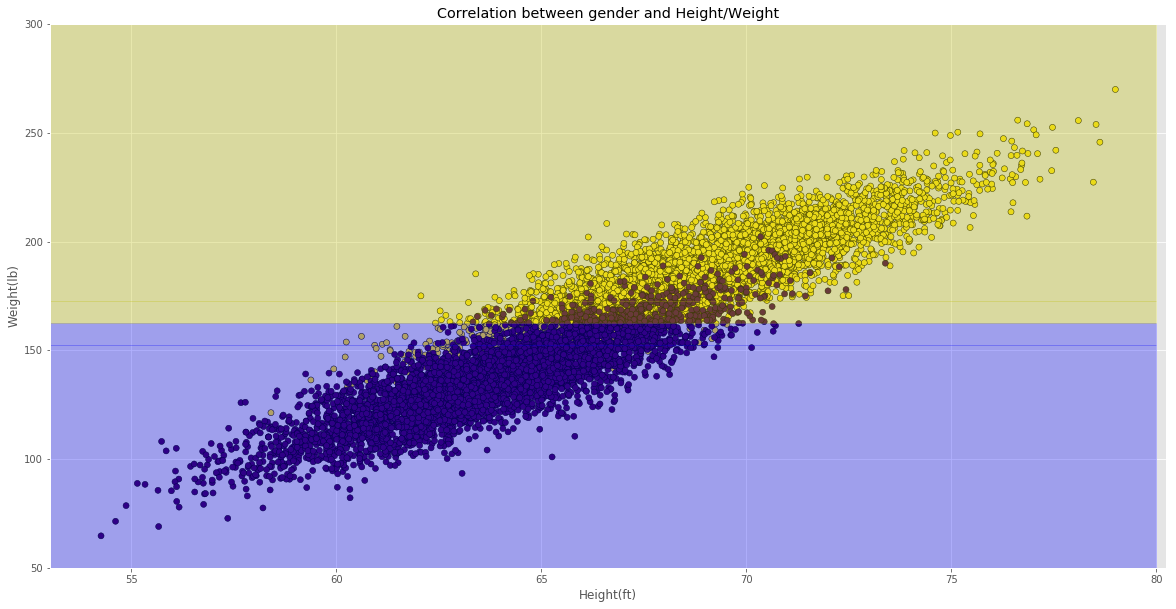

In [37]:
x_columns = ['Height', 'Weight']
X = df[x_columns]
x1 = df['Height']
x2 = df['Weight']
y = df.Male

plt.figure(figsize=(20, 10))
plt.scatter(x1, x2, c=y, edgecolor="black")
rectangles = decision_areas(dtree, [50, 80, 50, 300])
plot_areas(rectangles)
plt.title('Correlation between gender and Height/Weight')
plt.xlabel('Height(ft)')
plt.ylabel('Weight(lb)')
plt.ylim(50,300)
plt.show()

In [27]:
lin_clf2 = linear_model.LogisticRegression().fit(X, y)

C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [28]:
lin_clf2.predict_proba(X)

array([[4.66914000e-06, 9.99995331e-01],
       [7.24068477e-01, 2.75931523e-01],
       [1.63987427e-03, 9.98360126e-01],
       ...,
       [9.94899001e-01, 5.10099871e-03],
       [6.86102415e-01, 3.13897585e-01],
       [9.99304987e-01, 6.95013232e-04]])

In [29]:
all_ones = np.ones(len(y))
print('baseline ones accuracy: ', accuracy_score(y, all_ones))
all_ones = np.zeros(len(y))
print('baseline zeros accuracy: ', accuracy_score(y, all_ones))
y_pred = lin_clf2.predict(X)
print('lin_clf2 accuracy: ', accuracy_score(y, y_pred))


confusion_matrix=cm(y, y_pred)
list1 = ["Actual 0", "Actual 1"]
list2 = ["Predicted 0", "Predicted 1"]
pd.DataFrame(confusion_matrix, list1,list2)

baseline ones accuracy:  0.5
baseline zeros accuracy:  0.5
lin_clf2 accuracy:  0.9195


Predicted 0  Predicted 1
Actual 0         4591          409
Actual 1          396         4604

Q2 End

Q3 Compare the accuracy of the two models


Q3-1 Which model has a better accuracy?

Answer: Since the logistic model has less error than decision tree model, the logistic model is more accurate.

Q3-2 Would logloss or accuracy be better in this case (check the class balance...you can simply compare what the accuracy would be predicting all 1's or 0's)

Answer: 


Q3 End

Q4 Compare the confusion matrix for each model and write some thoughts (I just want to see that you understand the concepts here..)

Answer: